In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm import tqdm
import plotly.io as pio
#pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px

# Check version
print('torch version: ', torch.__version__)

torch version:  1.9.1


In [29]:
# FashionMNIST Data Download
data_dir = './data'

train_dataset = torchvision.datasets.FashionMNIST(root = data_dir,
                                                  train = True,
                                                  download = True,
                                                  transform = transforms.ToTensor()) 

test_dataset = torchvision.datasets.FashionMNIST(root = data_dir,
                                                 train = False,
                                                 download = True,
                                                 transform = transforms.ToTensor())

# Check Data size
size_of_train  = len(train_dataset)
size_of_test  = len(test_dataset)
num_of_class = 10

print('The Shape of dataset:', train_dataset[0][0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(torch.min(train_dataset[0][0]), torch.mean(train_dataset[0][0]), torch.max(train_dataset[0][0])))
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

The Shape of dataset: torch.Size([1, 28, 28])
Value MIN: 0, MEAN:0.38, MAX:1
The number of train image: 60000
The number of test image: 10000


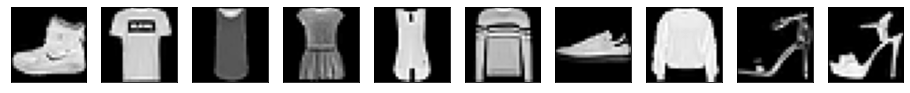

In [30]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [31]:
# Dataload
# random_split randomly split a dataset into non-overlapping new datasets of given lengths
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)]) # 20:80 비율로 train, val 나눔

batch_size=16

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)

valid_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                           batch_size = batch_size, 
                                           shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

print('The number of train data:', len(train_data))
print('The number of valid data:', len(val_data))
print('The number of test data:', len(test_dataset))

The number of train data: 48000
The number of valid data: 12000
The number of test data: 10000


In [32]:
# X_train, y_train shape
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) 
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [33]:
# channel attention
class channel_attention(nn.Module):    
    def __init__(self, channel, scale_factor=4):
        super(channel_attention, self).__init__()
        self.GAP = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//scale_factor, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//scale_factor, channel, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.GAP(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)

# spatial attention    
class spatial_attention(nn.Module):   
    def __init__(self, channel):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=3, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
    
# parallel add attention
class parallel_add_attention(nn.Module):   
    def __init__(self, channel, scale_factor):
        super(parallel_add_attention, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
    
        return y1 + y2
    
# parallel mul attention
class parallel_mul_attention(nn.Module):   
    def __init__(self, channel, scale_factor):
        super(parallel_mul_attention, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
    
        return y1 * y2
    
# serial CA    
class serial_CA(nn.Module):
    def __init__(self, channel, scale_factor):
        super(serial_CA, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
        
    def forward(self, x):
        y = self.CA(x)
        y = self.SA(y)
    
        return y
    
# serial SA    
class serial_SA(nn.Module):
    def __init__(self, channel, scale_factor):
        super(serial_SA, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
        
    def forward(self, x):
        y = self.SA(x)
        y = self.CA(y)
    
        return y
        
# attention_module
class attention_module(nn.Module):
    def __init__(self, channel, attention_type=None, scale_factor=None):
        super(attention_module, self).__init__()
        
        if attention_type == 'channel':
            # Channel Attnetion only
            self.attention_layer = channel_attention(channel, scale_factor)
        
        elif attention_type == 'spatial':
            # Spatial Attention only
            self.attention_layer = spatial_attention(channel)
        
        elif attention_type == 'parellel_add':
            # Parelle Attention (Add)
            self.attention_layer = parallel_add_attention(channel, scale_factor)

        elif attention_type == 'parellel_mul':
            # Parelle Attention (Mul)
            self.attention_layer = parallel_mul_attention(channel, scale_factor)

        elif attention_type == 'serial_ca':
            # Serial Attention, CA first
            self.attention_layer = serial_CA(channel, scale_factor)

        elif attention_type == 'serial_sa':
            # Serial Attention, SA first
            self.attention_layer = serial_SA(channel, scale_factor)

        elif attention_type == None and scale_factor == None:
            self.attention_layer = None
            
        else:
            self.attention_layer = None
    
    def forward(self, x):
        if self.attention_layer != None:
            out = self.attention_layer(x)
        else:
            out = x
        
        return out

In [34]:
# residual block
class res_block(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(res_block, self).__init__()
        self.stride = stride
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=1, stride = stride),
            nn.BatchNorm2d(output_dim)
        )
        
        self.res_layer = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size = 1, stride = stride),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace = True),
            nn.Conv2d(output_dim, output_dim, kernel_size = 1, stride = 1, padding = 'same'),
            nn.BatchNorm2d(output_dim)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        if self.stride != 1:
            residual = self.input_layer(x)
        out = self.res_layer(x)
        out += residual
        out = self.relu(out)
        
        return out

In [35]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, attention_type=None, scale_factor=None, num_classes=10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = (7-1)//2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=(3-1)//2),
            res_block(input_dim=64, output_dim=64, stride=2),
            attention_module(64, attention_type, scale_factor),
            res_block(input_dim=64, output_dim=64, stride=1),
            attention_module(64, attention_type, scale_factor),
            res_block(input_dim=64, output_dim=128, stride=2),
            attention_module(128, attention_type, scale_factor),
            res_block(input_dim=128, output_dim=128, stride=1),
            attention_module(128, attention_type, scale_factor),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [36]:
torch.manual_seed(0)

model_normal = ResNet()
model_channel = ResNet(attention_type='channel', scale_factor=4)
model_spatial = ResNet(attention_type='spatial')
model_parellel_add = ResNet(attention_type='parellel_add', scale_factor=4)
model_parellel_mul = ResNet(attention_type='parellel_mul', scale_factor=4)
model_serial_ca = ResNet(attention_type='serial_ca', scale_factor=4)
model_serial_sa = ResNet(attention_type='serial_sa', scale_factor=4)

In [37]:
import torchsummary
torchsummary.summary(model_normal, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
 attention_module-14             [-1, 6

In [38]:
torchsummary.summary(model_channel, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [39]:
torchsummary.summary(model_spatial, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
           Conv2d-14              [-1, 

In [40]:
torchsummary.summary(model_parellel_add, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [41]:
torchsummary.summary(model_parellel_mul, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [42]:
torchsummary.summary(model_serial_ca, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [43]:
torchsummary.summary(model_serial_sa, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
           Conv2d-14              [-1, 

In [44]:
### Define the loss function
criterion = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

optim1 = torch.optim.Adam(model_normal.parameters(), lr=lr, weight_decay=1e-05)
optim2 = torch.optim.Adam(model_channel.parameters(), lr=lr, weight_decay=1e-05)
optim3 = torch.optim.Adam(model_spatial.parameters(), lr=lr, weight_decay=1e-05)
optim4 = torch.optim.Adam(model_parellel_add.parameters(), lr=lr, weight_decay=1e-05)
optim5 = torch.optim.Adam(model_parellel_mul.parameters(), lr=lr, weight_decay=1e-05)
optim6 = torch.optim.Adam(model_serial_ca.parameters(), lr=lr, weight_decay=1e-05)
optim7 = torch.optim.Adam(model_serial_sa.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move both the encoder and the decoder to the selected device
model_normal = model_normal.to(device)
model_channel = model_channel.to(device)
model_spatial = model_spatial.to(device)
model_parellel_add = model_parellel_add.to(device)
model_parellel_mul = model_parellel_mul.to(device)
model_serial_ca = model_serial_ca.to(device)
model_serial_sa = model_serial_sa.to(device)

In [45]:
# EPOCHS
EPOCHS = 30

In [46]:
# model_normal

model_normal_train_loss = []
model_normal_val_loss = []
model_normal_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_normal.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_normal(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim1.zero_grad()
        loss.backward()
        optim1.step()
        
    # evaluate
    model_normal.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_normal(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_normal_train_loss.append(train_loss)
    model_normal_val_loss.append(val_loss)
    model_normal_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0381     train_accuracy : 0.7829     val_loss : 0.0340     val_accuracy : 0.7934
epoch 2 :  train_loss : 0.0302     train_accuracy : 0.8238     val_loss : 0.0301     val_accuracy : 0.8230
epoch 3 :  train_loss : 0.0277     train_accuracy : 0.8356     val_loss : 0.0304     val_accuracy : 0.8200
epoch 4 :  train_loss : 0.0261     train_accuracy : 0.8457     val_loss : 0.0283     val_accuracy : 0.8380
epoch 5 :  train_loss : 0.0249     train_accuracy : 0.8526     val_loss : 0.0315     val_accuracy : 0.8210
epoch 6 :  train_loss : 0.0239     train_accuracy : 0.8590     val_loss : 0.0261     val_accuracy : 0.8513
epoch 7 :  train_loss : 0.0230     train_accuracy : 0.8644     val_loss : 0.0256     val_accuracy : 0.8546
epoch 8 :  train_loss : 0.0224     train_accuracy : 0.8674     val_loss : 0.0294     val_accuracy : 0.8210
epoch 9 :  train_loss : 0.0218     train_accuracy : 0.8690     val_loss : 0.0261     val_accuracy : 0.8491
epoch 10 :  train_loss : 0.0213     t

In [47]:
# model_channel

model_channel_train_loss = []
model_channel_val_loss = []
model_channel_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_channel.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_channel(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim2.zero_grad()
        loss.backward()
        optim2.step()
        
    # evaluate
    model_channel.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_channel(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_channel_train_loss.append(train_loss)
    model_channel_val_loss.append(val_loss)
    model_channel_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0372     train_accuracy : 0.7885     val_loss : 0.0282     val_accuracy : 0.8347
epoch 2 :  train_loss : 0.0265     train_accuracy : 0.8452     val_loss : 0.0264     val_accuracy : 0.8494
epoch 3 :  train_loss : 0.0234     train_accuracy : 0.8619     val_loss : 0.0239     val_accuracy : 0.8550
epoch 4 :  train_loss : 0.0214     train_accuracy : 0.8739     val_loss : 0.0214     val_accuracy : 0.8719
epoch 5 :  train_loss : 0.0203     train_accuracy : 0.8792     val_loss : 0.0215     val_accuracy : 0.8760
epoch 6 :  train_loss : 0.0193     train_accuracy : 0.8855     val_loss : 0.0222     val_accuracy : 0.8696
epoch 7 :  train_loss : 0.0185     train_accuracy : 0.8894     val_loss : 0.0203     val_accuracy : 0.8815
epoch 8 :  train_loss : 0.0176     train_accuracy : 0.8960     val_loss : 0.0214     val_accuracy : 0.8751
epoch 9 :  train_loss : 0.0168     train_accuracy : 0.8989     val_loss : 0.0235     val_accuracy : 0.8621
epoch 10 :  train_loss : 0.0164     t

In [48]:
# model_spatial

model_spatial_train_loss = []
model_spatial_val_loss = []
model_spatial_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_spatial.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_spatial(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim3.zero_grad()
        loss.backward()
        optim3.step()
        
    # evaluate
    model_spatial.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_spatial(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_spatial_train_loss.append(train_loss)
    model_spatial_val_loss.append(val_loss)
    model_spatial_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0347     train_accuracy : 0.7999     val_loss : 0.0287     val_accuracy : 0.8248
epoch 2 :  train_loss : 0.0253     train_accuracy : 0.8521     val_loss : 0.0256     val_accuracy : 0.8489
epoch 3 :  train_loss : 0.0225     train_accuracy : 0.8677     val_loss : 0.0242     val_accuracy : 0.8542
epoch 4 :  train_loss : 0.0211     train_accuracy : 0.8770     val_loss : 0.0222     val_accuracy : 0.8727
epoch 5 :  train_loss : 0.0199     train_accuracy : 0.8841     val_loss : 0.0226     val_accuracy : 0.8642
epoch 6 :  train_loss : 0.0189     train_accuracy : 0.8898     val_loss : 0.0210     val_accuracy : 0.8816
epoch 7 :  train_loss : 0.0181     train_accuracy : 0.8939     val_loss : 0.0206     val_accuracy : 0.8831
epoch 8 :  train_loss : 0.0174     train_accuracy : 0.8999     val_loss : 0.0203     val_accuracy : 0.8821
epoch 9 :  train_loss : 0.0168     train_accuracy : 0.9019     val_loss : 0.0202     val_accuracy : 0.8873
epoch 10 :  train_loss : 0.0164     t

In [49]:
# model_parellel_add

model_parellel_add_train_loss = []
model_parellel_add_val_loss = []
model_parellel_add_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_parellel_add.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_parellel_add(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim4.zero_grad()
        loss.backward()
        optim4.step()
        
    # evaluate
    model_parellel_add.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_parellel_add(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_parellel_add_train_loss.append(train_loss)
    model_parellel_add_val_loss.append(val_loss)
    model_parellel_add_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0337     train_accuracy : 0.8056     val_loss : 0.0268     val_accuracy : 0.8454
epoch 2 :  train_loss : 0.0249     train_accuracy : 0.8536     val_loss : 0.0246     val_accuracy : 0.8542
epoch 3 :  train_loss : 0.0223     train_accuracy : 0.8687     val_loss : 0.0230     val_accuracy : 0.8627
epoch 4 :  train_loss : 0.0207     train_accuracy : 0.8773     val_loss : 0.0221     val_accuracy : 0.8728
epoch 5 :  train_loss : 0.0193     train_accuracy : 0.8872     val_loss : 0.0211     val_accuracy : 0.8768
epoch 6 :  train_loss : 0.0183     train_accuracy : 0.8917     val_loss : 0.0221     val_accuracy : 0.8715
epoch 7 :  train_loss : 0.0174     train_accuracy : 0.8957     val_loss : 0.0214     val_accuracy : 0.8734
epoch 8 :  train_loss : 0.0168     train_accuracy : 0.8993     val_loss : 0.0213     val_accuracy : 0.8769
epoch 9 :  train_loss : 0.0163     train_accuracy : 0.9024     val_loss : 0.0205     val_accuracy : 0.8838
epoch 10 :  train_loss : 0.0156     t

In [50]:
# model_parellel_mul

model_parellel_mul_train_loss = []
model_parellel_mul_val_loss = []
model_parellel_mul_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_parellel_mul.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_parellel_mul(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim5.zero_grad()
        loss.backward()
        optim5.step()
        
    # evaluate
    model_parellel_mul.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_parellel_mul(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_parellel_mul_train_loss.append(train_loss)
    model_parellel_mul_val_loss.append(val_loss)
    model_parellel_mul_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0440     train_accuracy : 0.7501     val_loss : 0.0341     val_accuracy : 0.8013
epoch 2 :  train_loss : 0.0289     train_accuracy : 0.8322     val_loss : 0.0282     val_accuracy : 0.8361
epoch 3 :  train_loss : 0.0253     train_accuracy : 0.8528     val_loss : 0.0261     val_accuracy : 0.8452
epoch 4 :  train_loss : 0.0232     train_accuracy : 0.8656     val_loss : 0.0248     val_accuracy : 0.8550
epoch 5 :  train_loss : 0.0215     train_accuracy : 0.8740     val_loss : 0.0232     val_accuracy : 0.8616
epoch 6 :  train_loss : 0.0203     train_accuracy : 0.8823     val_loss : 0.0221     val_accuracy : 0.8705
epoch 7 :  train_loss : 0.0194     train_accuracy : 0.8852     val_loss : 0.0213     val_accuracy : 0.8745
epoch 8 :  train_loss : 0.0188     train_accuracy : 0.8900     val_loss : 0.0217     val_accuracy : 0.8764
epoch 9 :  train_loss : 0.0179     train_accuracy : 0.8950     val_loss : 0.0200     val_accuracy : 0.8860
epoch 10 :  train_loss : 0.0173     t

In [51]:
# model_serial_ca

model_serial_ca_train_loss = []
model_serial_ca_val_loss = []
model_serial_ca_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_serial_ca.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_serial_ca(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim6.zero_grad()
        loss.backward()
        optim6.step()
        
    # evaluate
    model_serial_ca.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_serial_ca(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_serial_ca_train_loss.append(train_loss)
    model_serial_ca_val_loss.append(val_loss)
    model_serial_ca_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0344     train_accuracy : 0.8025     val_loss : 0.0329     val_accuracy : 0.8030
epoch 2 :  train_loss : 0.0249     train_accuracy : 0.8559     val_loss : 0.0238     val_accuracy : 0.8582
epoch 3 :  train_loss : 0.0223     train_accuracy : 0.8687     val_loss : 0.0237     val_accuracy : 0.8551
epoch 4 :  train_loss : 0.0205     train_accuracy : 0.8804     val_loss : 0.0226     val_accuracy : 0.8683
epoch 5 :  train_loss : 0.0193     train_accuracy : 0.8855     val_loss : 0.0211     val_accuracy : 0.8757
epoch 6 :  train_loss : 0.0185     train_accuracy : 0.8926     val_loss : 0.0202     val_accuracy : 0.8807
epoch 7 :  train_loss : 0.0176     train_accuracy : 0.8964     val_loss : 0.0200     val_accuracy : 0.8837
epoch 8 :  train_loss : 0.0168     train_accuracy : 0.9006     val_loss : 0.0199     val_accuracy : 0.8822
epoch 9 :  train_loss : 0.0161     train_accuracy : 0.9039     val_loss : 0.0196     val_accuracy : 0.8858
epoch 10 :  train_loss : 0.0157     t

In [52]:
# model_serial_sa

model_serial_sa_train_loss = []
model_serial_sa_val_loss = []
model_serial_sa_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_serial_sa.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_serial_sa(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim7.zero_grad()
        loss.backward()
        optim7.step()
        
    # evaluate
    model_serial_sa.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_serial_sa(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_serial_sa_train_loss.append(train_loss)
    model_serial_sa_val_loss.append(val_loss)
    model_serial_sa_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.0340     train_accuracy : 0.8071     val_loss : 0.0273     val_accuracy : 0.8385
epoch 2 :  train_loss : 0.0248     train_accuracy : 0.8541     val_loss : 0.0229     val_accuracy : 0.8670
epoch 3 :  train_loss : 0.0222     train_accuracy : 0.8711     val_loss : 0.0230     val_accuracy : 0.8651
epoch 4 :  train_loss : 0.0206     train_accuracy : 0.8789     val_loss : 0.0229     val_accuracy : 0.8684
epoch 5 :  train_loss : 0.0195     train_accuracy : 0.8846     val_loss : 0.0214     val_accuracy : 0.8736
epoch 6 :  train_loss : 0.0185     train_accuracy : 0.8911     val_loss : 0.0207     val_accuracy : 0.8811
epoch 7 :  train_loss : 0.0176     train_accuracy : 0.8969     val_loss : 0.0190     val_accuracy : 0.8874
epoch 8 :  train_loss : 0.0170     train_accuracy : 0.8992     val_loss : 0.0190     val_accuracy : 0.8876
epoch 9 :  train_loss : 0.0164     train_accuracy : 0.9028     val_loss : 0.0197     val_accuracy : 0.8891
epoch 10 :  train_loss : 0.0159     t

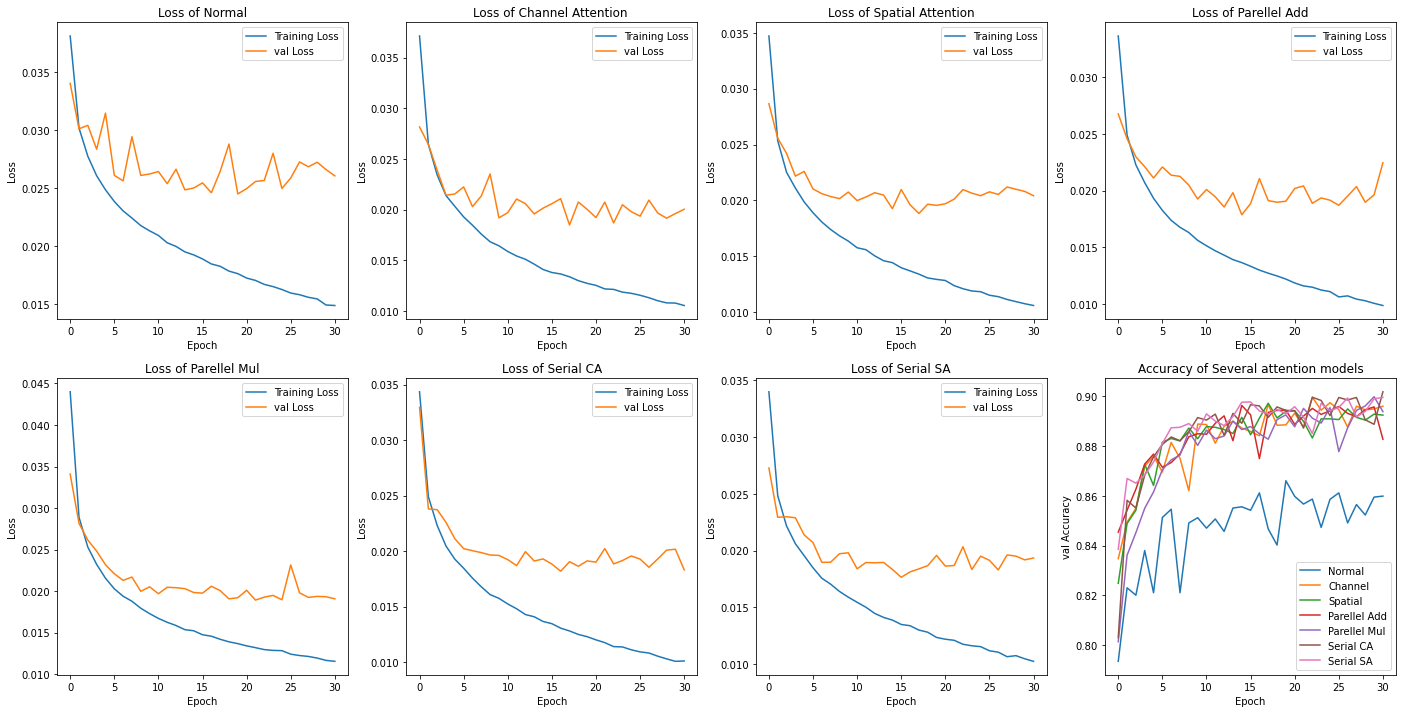

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))

plt.subplot(2,4,1)
plt.plot(model_normal_train_loss)
plt.plot(model_normal_val_loss)
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(model_channel_train_loss)
plt.plot(model_channel_val_loss)
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(model_spatial_train_loss)
plt.plot(model_spatial_val_loss)
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(model_parellel_add_train_loss)
plt.plot(model_parellel_add_val_loss)
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(model_parellel_mul_train_loss)
plt.plot(model_parellel_mul_val_loss)
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,6)
plt.plot(model_serial_ca_train_loss)
plt.plot(model_serial_ca_val_loss)
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,7)
plt.plot(model_serial_sa_train_loss)
plt.plot(model_serial_sa_val_loss)
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,8)
plt.plot(model_normal_val_accuracy)
plt.plot(model_channel_val_accuracy)
plt.plot(model_spatial_val_accuracy)
plt.plot(model_parellel_add_val_accuracy)
plt.plot(model_parellel_mul_val_accuracy)
plt.plot(model_serial_ca_val_accuracy)
plt.plot(model_serial_sa_val_accuracy)

plt.title('Accuracy of Several attention models')
plt.ylabel('val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel', 'Spatial', 'Parellel Add', 'Parellel Mul', 'Serial CA', 'Serial SA'], loc=0)

plt.show()